In [1]:
import numpy as np
import pandas as pd
# %matplotlib notebook
import pickle
import os
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from collections import Counter
from sklearn import metrics
from datetime import datetime
from utils.utils import *
from joblib import Parallel, delayed
from copy import deepcopy
import math

def return_important_vars(episode_presence,n_lag=15,n_cluster = 2,obs = 30):
    data_file = './data/episode_encoded_lagged_data_with_episode/episode_encoded_'+'lagged_'+str(n_lag)+'_obs_{}'.format(obs)+'_windows_with_episode_cluster_check_{}'.format(n_cluster)
    if episode_presence==0:
        episode_label = 'only'
    elif episode_presence==1:
        episode_label = 'with'
    elif episode_presence==2:
        episode_label = 'no'
    filename = './data/output_final_all/result_'+str(episode_label)+'_episode_lag_{}_obs_{}_triplet_loss_cluster_{}.p'.format(n_lag,obs,n_cluster)        
    data_eval = pickle.load(open(filename,'rb'))
    file1 = './data/mRisk/mRisk_Lapse_postquit.csv'
    puff_data = pd.read_csv(file1)
    data_feature_label = pickle.load(open(data_file,'rb'))
    data_cluster = pickle.load(open(data_file,'rb'))
    temp = data_cluster.groupby(['user','cluster_label']).count().index.values
    users = np.array([a[0] for a in temp])
    labels = np.array([a[1] for a in temp])
    cluster_dict = {}
    for i,a in enumerate(users):
        cluster_dict[a] = labels[i]
    y_time,y_pred,y_test,y_pid,bias_dict,val_results = data_eval[0],np.array(data_eval[1]),data_eval[2],data_eval[3],data_eval[4],data_eval[5]
    y_time,y_pred,y_test,y_pid,pars = np.array(y_time),np.array(y_pred).reshape(len(y_test),-1),np.array(y_test),np.array(y_pid),np.unique(y_pid)
    lapse_captured_dict = {}
    total_lapsers = 0
    result_phenotypes_final = {}
    return y_pred, y_test, y_time, y_pid, lapse_captured_dict, result_phenotypes_final, cluster_dict, puff_data, data_feature_label, total_lapsers, pars, bias_dict

n_lag = 15
n_cluster = 4
obs = 30
label = 'DRES'
all_dfs = []
from sklearn.preprocessing import MinMaxScaler
for episode_presence in [0,2]:
    y_pred, y_test, y_time, y_pid, lapse_captured_dict, result_phenotypes_final, cluster_dict, puff_data, data_feature_label, total_lapsers, pars, bias_dict = return_important_vars(episode_presence=episode_presence,n_lag=n_lag)
    if episode_presence==0:
        label = 'DDHI'
    elif episode_presence==1:
        label = 'DDHI (Only Episode)'
    elif episode_presence==2:
        label = 'DRES'
    y_pred_final = []
    print(y_pred.shape)
    for user in np.unique(y_pid):
        a = np.where(y_pid==user)[0]
        y_pred_pid = y_pred[a]
        biases = np.array(bias_dict[user])
        # np.percentile(y_pred_pid[:,ii],80)
        # if label=='DRES':
        # y_pred_pid = MinMaxScaler().fit_transform(y_pred_pid)
        for ii in range(y_pred_pid.shape[1]):
            y_pred_pid[:,ii] = np.array(y_pred_pid[:,ii]>=np.percentile(y_pred_pid[:,ii],65),dtype=int)
        y_pred_pid = np.mean(y_pred_pid,axis=1) 
        y_pred_final.extend(list(y_pred_pid))
    df = pd.DataFrame({'Original':y_test,'Predicted':y_pred_final,'User':y_pid,'Time':y_time})
    df['Model'] = [label]*df.shape[0]
    all_dfs.append(df)

df_final = pd.concat(all_dfs)
# df_final.Predicted.plot(kind='hist')
def get_lapse_times(puff_data,par):
    return np.array([np.datetime64(datetime.fromtimestamp(lapse_time/1000)) for lapse_time in puff_data[puff_data['Participant']==int(par)]['Lapse'].values])


def get_positive_only_prediction(df):
    df = df.sort_values('Time').reset_index(drop=True)
    lapse_times = get_lapse_times(puff_data,df['User'].values[0])
    if len(lapse_times)==0:
        return pd.DataFrame([],columns=df.columns)
    df['Lapse'] = [-1]*df.shape[0]
    indexes = []
    for i,row in df.iterrows():
        for j,lapse in enumerate(lapse_times):
            if row['Time']<=lapse and abs((row['Time']-lapse).total_seconds()/60)<=60:
                indexes.append(i)
                df['Lapse'].at[i] = j
    return df.loc[indexes]

df_all_final = df_final.groupby(['User','Model'],as_index=False).apply(get_positive_only_prediction)

final_df = []
final_df_burden = []
for bias in np.arange(0.02,1,.01):
    def get_results(df):
        if df.shape[0]<5:
            return pd.DataFrame([],columns=['y_test','y_pred','user','Model'])
        model_name = df['Model'].values[0]
        user = df['User'].values[0]
        if np.max(df['Predicted'])>=bias:
            y_pred = 1
        else:
            y_pred = 0
        return pd.DataFrame({'y_test':[1],'y_pred':[y_pred],'user':[user],'Model':[model_name]})

    results = df_all_final.groupby(['User','Model','Lapse'],as_index=False).apply(get_results).reset_index(drop=True)
    from sklearn.metrics import accuracy_score
    results['y_test'] = np.int64(results['y_test'])
    results['y_pred'] = np.int64(results['y_pred']) 
    results_scores = results.groupby('Model',as_index=False).apply(lambda a:pd.Series({'Accuracy':accuracy_score(a['y_test'],a['y_pred'])}))
    results_scores['Bias'] = bias
    final_df.append(results_scores)
    temp_data = []
    for model in ['DDHI','DRES']:
        ratio_ = 100*df_final[df_final.Model.isin([model])&(df_final.Predicted>bias)].shape[0]/df_final[df_final.Model.isin([model])].shape[0]
        temp_data.append([model,bias,ratio_])
    final_df_burden.append(pd.DataFrame(temp_data,columns=['Model','Bias','Accuracy']))
df_burden = pd.concat(final_df_burden)
final_df_result = pd.concat(final_df)

(27959, 50)
(27959, 50)


In [ ]:
df1 = final_df_result.groupby(['Model','Bias'],as_index=False).mean()

In [ ]:
df1[(df1.Accuracy>.72)&(df1.Accuracy<.84)&(df1.Model!='DDHI')].sort_values('Bias')

In [ ]:
results_scores

In [ ]:



import seaborn as sns
plt.figure(figsize=(10,8))
sns.ecdfplot(data=  df_final.reset_index(drop=True), x="Predicted",hue='Model')

In [ ]:
import seaborn as sns
plt.rcParams.update({'font.size':15})
plt.figure(figsize=(8,5))
sns.lineplot(x='Bias',y='Accuracy',hue='Model',data=final_df_result[final_df_result.Model!='DHI'].reset_index(drop=True))
plt.vlines([.620],0,.8,color='tab:blue',linestyle='--',label=r'$B_L, DDHI$')
plt.vlines([.5],0,.8,color='orange',linestyle='--',label=r'$B_L, DRES$')
plt.text(.45,.45,r'$B_L = 0.5$',color='orange',rotation=90)
plt.text(.57,.32,r'$B_L = 0.62$',color='tab:blue',rotation=90)
# plt.arrow(x=.499, y=.4, dx=.08, dy=0, width=.01,label='Improvement in ') 
# plt.vlines([.5],0,1,color='g',linestyle='--',label='Decision Threshold')
plt.hlines([.8],0,.620,color='k',linestyle='-.',label='Accuracy = 0.8')
plt.ylim([0,1.1])
plt.xlim([0,1.1])
plt.legend(loc='lower left',frameon=False)
plt.xlabel('High Risk Decision Threshold, '+r'$B_L$')
plt.ylabel('Lapse Event \nDetection Accuracy')
plt.tight_layout()
# plt.savefig('./data/images/detection_accuracy.png')
plt.show()

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.lineplot(x='Bias',y='Accuracy',hue='Model',data=df_burden.reset_index(drop=True))
plt.vlines([0.62],0,28.88,color='tab:blue',linestyle='--')
plt.vlines([0.5],0,44.014,color='orange',linestyle='--')
plt.text(.45,2,r'$B_L = 0.5$',color='orange',rotation=90)
plt.text(.57,2,r'$B_L = 0.62$',color='tab:blue',rotation=90)

plt.hlines([28.88,44.014],[0,0],[.62,.5],color='k',linestyle='--')
plt.text(.1,45,'Perc. = {}%'.format(44.01),color='orange')
plt.text(.1,30,'Perc. = {}%'.format(28.88),color='tab:blue')
# plt.arrow(x=.2, y=28.88, dx=0, dy=12, width=.01,head_width=0.02,head_length=0.02,color='g',length_includes_head=True)
# plt.text(.21,30.5,'Improvement \nfor DDHI (~12%)',color='g') 
plt.ylim([0,110])
plt.xlim([0,1.1])
plt.legend()
plt.xlabel('High Risk Decision Threshold, '+r'$B_L$')
plt.ylabel('Percentage of Assessment Windows \nlabelled High Risk')
plt.tight_layout()
# plt.savefig('./data/images/burden.png')
plt.show()

In [ ]:
import seaborn as sns
plt.rcParams.update({'font.size':17})
plt.figure(figsize=(8,5))
sns.kdeplot(x='Predicted',hue='Model',data=df_final.reset_index(drop=True),multiple='layer',common_norm=False,fill=False)
plt.xlabel('mRisk Lapse Likelihood')
# plt.ylabel('Frequency')
# plt.tight_layout()
# plt.savefig('./data/images/histogram_of_risk_likelihood.png')
plt.show()

In [2]:
df_final1 = df_final[df_final.Model=='DDHI']
df_final1['day'] = df_final1['Time'].apply(lambda a:str(a)[:10])

/tmp/ipykernel_14378/2520536407.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final1['day'] = df_final1['Time'].apply(lambda a:str(a)[:10])


In [7]:
df_final1

,Original,Predicted,User,Time,Model,day
0,0.0,0.268253,3002,2017-06-09 11:14:15.864,DDHI,2017-06-09
1,0.0,0.285728,3002,2017-06-09 11:16:15.864,DDHI,2017-06-09
2,0.0,0.318047,3002,2017-06-09 11:18:15.864,DDHI,2017-06-09
3,0.0,0.312225,3002,2017-06-09 11:20:15.864,DDHI,2017-06-09
4,0.0,0.281347,3002,2017-06-09 11:22:15.864,DDHI,2017-06-09
...,...,...,...,...,...,...
27954,1.0,0.585477,3168,2019-03-25 18:13:19.464,DDHI,2019-03-25
27955,1.0,0.590446,3168,2019-03-25 18:15:19.464,DDHI,2019-03-25
27956,1.0,0.649141,3168,2019-03-25 18:17:19.464,DDHI,2019-03-25
27957,1.0,0.678112,3168,2019-03-25 18:19:19.464,DDHI,2019-03-25


4510.3153


/tmp/ipykernel_14378/438566061.py:18: DeprecationWarning: an integer is required (got type Series).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  lapse_time = np.datetime64(datetime.fromtimestamp(lapse_time/1000))
/tmp/ipykernel_14378/438566061.py:33: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.vlines(x_int,0,1,color='k',Label='Intervention Times')


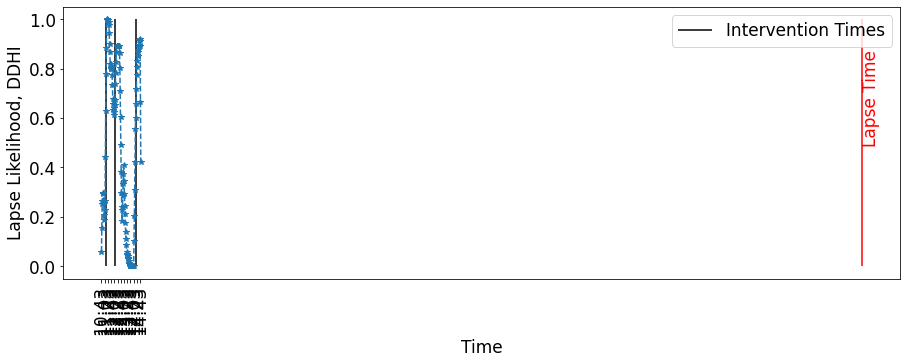

/tmp/ipykernel_14378/438566061.py:18: DeprecationWarning: an integer is required (got type Series).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  lapse_time = np.datetime64(datetime.fromtimestamp(lapse_time/1000))


22.12145


/tmp/ipykernel_14378/438566061.py:33: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.vlines(x_int,0,1,color='k',Label='Intervention Times')


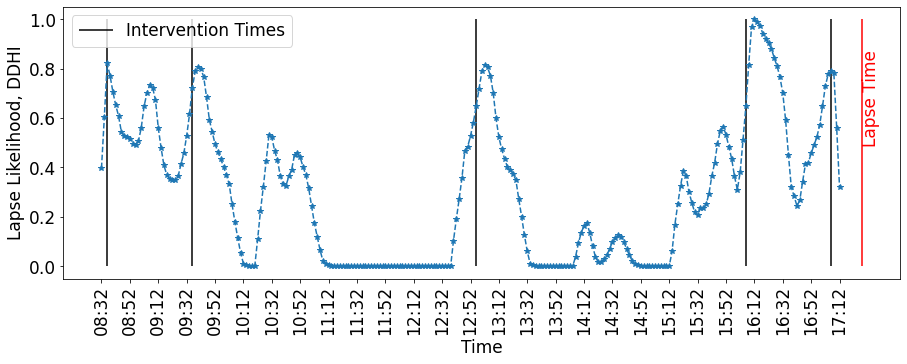

In [73]:
# inc = ['3002', '3004', '3005', '3006', '3007', '3009', '3013', '3014', '3015', '3022', '3024', '3025', '3029', '3031', '3033',
#  '3036', '3038', '3041', '3045', '3048', '3050', '3053', '3076', '3077', '3079', '3086', '3088', '3091', '3095', '3099',
#  '3101', '3102', '3122', '3125', '3126', '3128', '3133', '3135', '3137', '3138', '3139', '3143', '3145', '3148', '3152',
#  '3153', '3158', '3160', '3164', '3165', '3166', '3168']
plt.rcParams.update({'font.size':17})
bias = .62
from datetime import timedelta
ig = 60
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
inc = df_final1.User.unique()
for par in ['3004']:
    temp1 = df_final1[df_final1.User==par]
    for day in temp1.day.unique():
        lapse_time = puff_data[puff_data.Participant==3004]['Lapse']
        lapse_time = np.datetime64(datetime.fromtimestamp(lapse_time/1000))
        temp = temp1[temp1.day==day].sort_values('Time').reset_index(drop=True)
        x = temp['Time'].values
        y = MinMaxScaler().fit_transform(smooth(temp['Predicted'].values,5).reshape(-1,1)).reshape(-1)
        x_int = []
        y_int = []
        for i,row in enumerate(x):
            if y[i]<bias:
                continue
            if len(x_int)==0:
                x_int.append(row)
            elif (row-x_int[-1])/np.timedelta64(1, 'm') >=ig:
                x_int.append(row)
        plt.figure(figsize=(15,5))
        plt.plot(x,y,'*--',c='tab:blue')
        plt.vlines(x_int,0,1,color='k',Label='Intervention Times')
        plt.vlines([lapse_time-np.timedelta64(0,'m')],0,1,color='red')
        plt.text(lapse_time-np.timedelta64(0,'m'),.5,'Lapse Time',rotation=90,color='red')
        print((lapse_time-x_int[-1])/np.timedelta64(1,'m'))
        plt.xticks(x[np.arange(0,len(x),10)],np.array([str(a)[11:16] for a in x])[np.arange(0,len(x),10)],rotation=90)
        # plt.title(par+'-'+day)
        plt.xlabel('Time')
        plt.ylabel('Lapse Likelihood, DDHI')
        plt.legend()
        plt.show()

In [55]:
str(x_int[0])[11:16]

'08:36'

In [ ]:
import seaborn as sns
plt.rcParams.update({'font.size':15})
plt.figure(figsize=(7,5))
sns.histplot(y_pred_final,bins=10)
plt.xlabel('mRisk Lapse Likelihood (DDHI)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('./data/images/histogram_of_risk_likelihood.png')
plt.show()

In [ ]:
df.loc[df.shape[0]-1]

In [ ]:
df[-1:]